In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

Segmentation Models: using `tf.keras` framework.


In [3]:
#from keras.utils import normalize
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU

In [4]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
#n_classes=4

In [5]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("sandstone_data/128_patches/Images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        img = cv2.imread(img_path, 1)       
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [6]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("sandstone_data/128_patches/Masks/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        mask = cv2.imread(mask_path, 0)       
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [7]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0, 1, 2, 3], dtype=int64)

In [8]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [9]:
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, shuffle=True, random_state = 42)

#Further split training data to a smaller subset for quick training
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, shuffle=True, random_state = 42)

print("Class values in the dataset are ... ", np.unique(y_train))  

Class values in the dataset are ...  [0 1 2 3]


In [10]:
from keras.utils.np_utils import to_categorical

n_classes=4

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [11]:
#Reused parameters in all models

n_classes=4
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [12]:
#Inceptionv3
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

In [13]:
#Preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

In [14]:
#Define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

In [15]:
#Compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics=metrics)

In [15]:
print(model2.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
history2=model2.fit(X_train2, 
          y_train_cat,
          #batch_size=8, 
          #batch_size=16,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_test2, y_test_cat))

Epoch 1/50
23/23 [==============================] - 168s 6s/step - loss: 0.9958 - iou_score: 0.1507 - f1-score: 0.2433 - val_loss: 1.0238 - val_iou_score: 0.1314 - val_f1-score: 0.2155
Epoch 2/50
23/23 [==============================] - 141s 6s/step - loss: 0.9581 - iou_score: 0.3176 - f1-score: 0.4499 - val_loss: 1.0239 - val_iou_score: 0.1778 - val_f1-score: 0.2681
Epoch 3/50
23/23 [==============================] - 138s 6s/step - loss: 0.9357 - iou_score: 0.4599 - f1-score: 0.6150 - val_loss: 1.0050 - val_iou_score: 0.1997 - val_f1-score: 0.2978
Epoch 4/50
23/23 [==============================] - 148s 6s/step - loss: 0.9187 - iou_score: 0.5493 - f1-score: 0.6996 - val_loss: 0.9713 - val_iou_score: 0.2867 - val_f1-score: 0.4261
Epoch 5/50
23/23 [==============================] - 191s 8s/step - loss: 0.9051 - iou_score: 0.6016 - f1-score: 0.7427 - val_loss: 0.9678 - val_iou_score: 0.2864 - val_f1-score: 0.4338
Epoch 6/50
23/23 [==============================] - 193s 8s/step - loss: 0.

23/23 [==============================] - 191s 8s/step - loss: 0.7782 - iou_score: 0.8771 - f1-score: 0.9329 - val_loss: 0.8437 - val_iou_score: 0.6531 - val_f1-score: 0.7770
Epoch 46/50
23/23 [==============================] - 188s 8s/step - loss: 0.7783 - iou_score: 0.8748 - f1-score: 0.9314 - val_loss: 0.8453 - val_iou_score: 0.6446 - val_f1-score: 0.7694
Epoch 47/50
23/23 [==============================] - 190s 8s/step - loss: 0.7782 - iou_score: 0.8741 - f1-score: 0.9311 - val_loss: 0.8438 - val_iou_score: 0.6559 - val_f1-score: 0.7792
Epoch 48/50
23/23 [==============================] - 190s 8s/step - loss: 0.7775 - iou_score: 0.8770 - f1-score: 0.9326 - val_loss: 0.8442 - val_iou_score: 0.6543 - val_f1-score: 0.7777
Epoch 49/50
23/23 [==============================] - 191s 8s/step - loss: 0.7765 - iou_score: 0.8807 - f1-score: 0.9348 - val_loss: 0.8461 - val_iou_score: 0.6471 - val_f1-score: 0.7722
Epoch 50/50
23/23 [==============================] - 191s 8s/step - loss: 0.7755 -

In [17]:
model2.save('inceptionv3_backbone_50epochs_32_sandstone_f5.hdf5')

# Batch 8 - plots

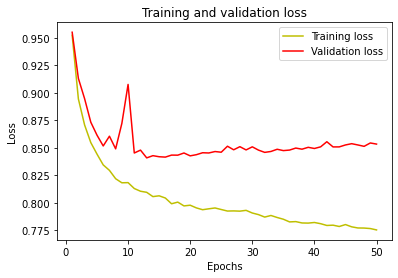

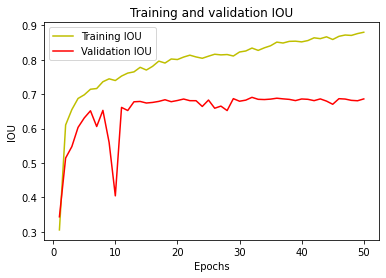

In [18]:
#Fold-1
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

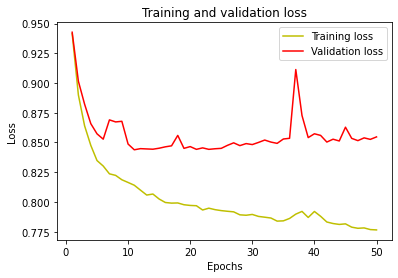

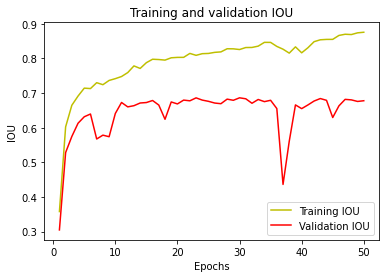

In [18]:
#Fold-2
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

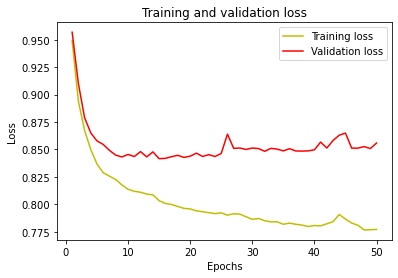

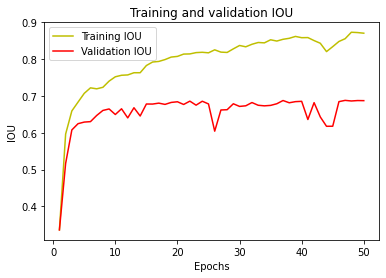

In [18]:
#Fold-3
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

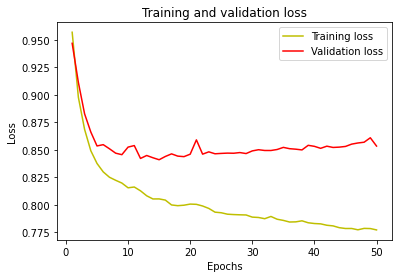

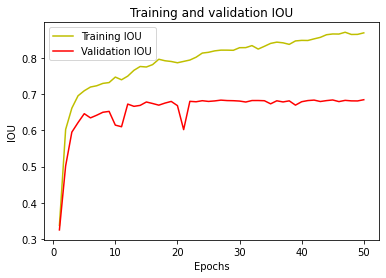

In [18]:
#Fold-4
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

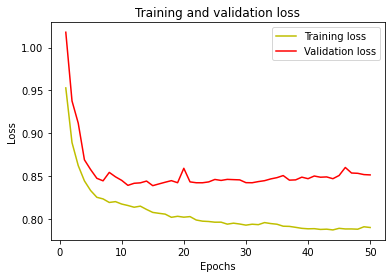

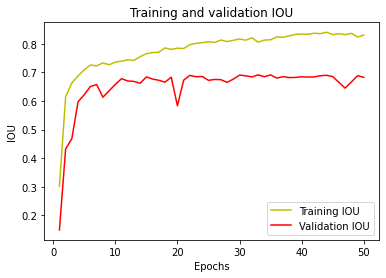

In [18]:
#Fold-5
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Batch 16 - plots

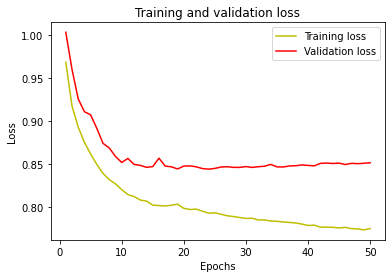

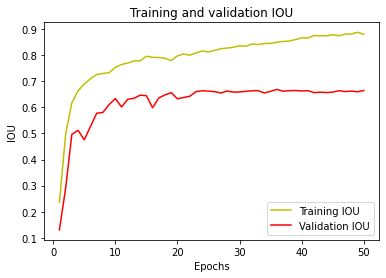

In [18]:
#Fold-1
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

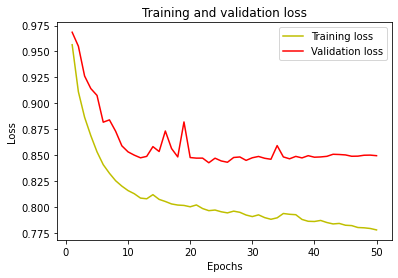

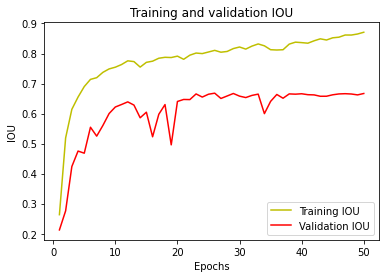

In [18]:
#Fold-2
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

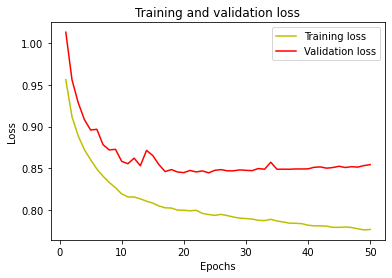

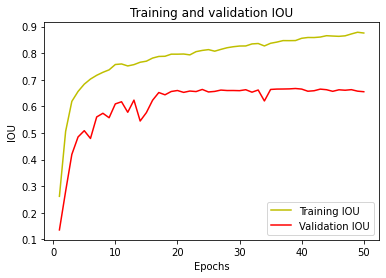

In [18]:
#Fold-3
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

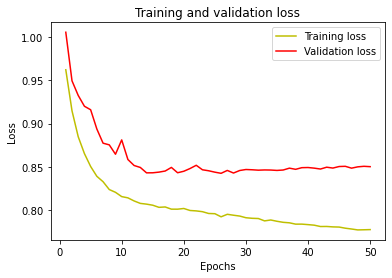

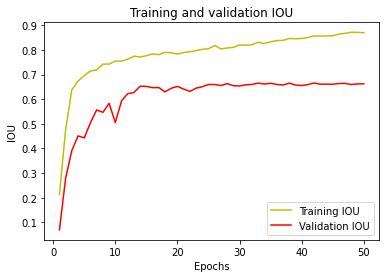

In [18]:
#Fold-4
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

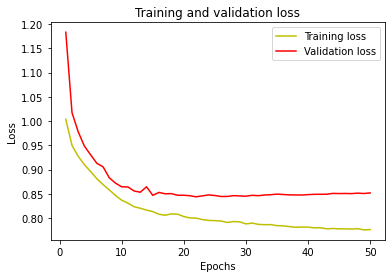

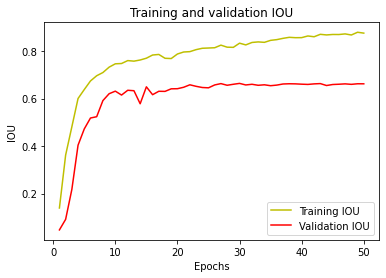

In [18]:
#Fold-5
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Batch 32 - plots

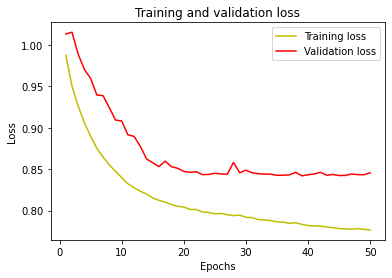

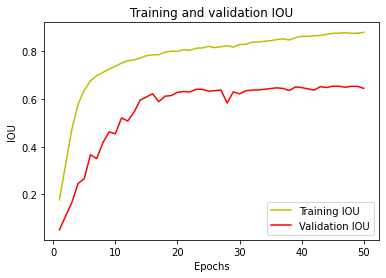

In [18]:
#Fold-1
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

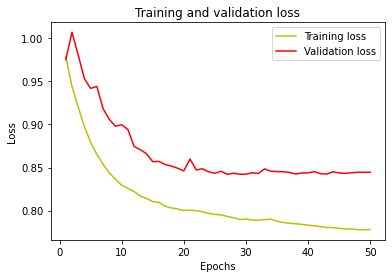

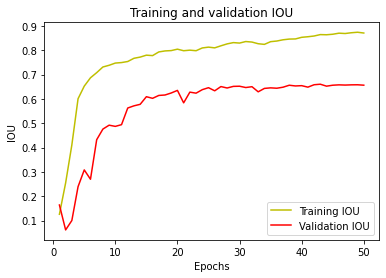

In [18]:
#Fold-2
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

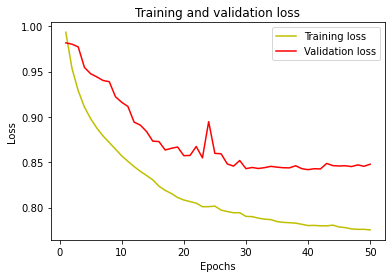

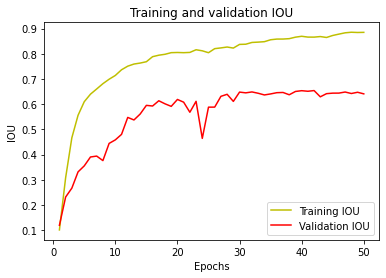

In [18]:
#Fold-3
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

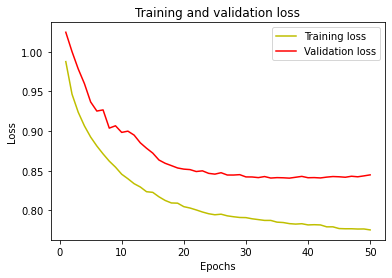

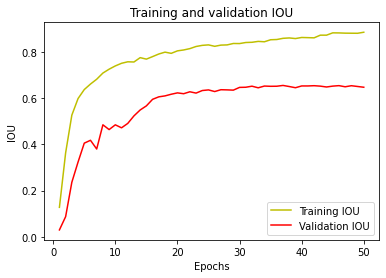

In [18]:
#Fold-4
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

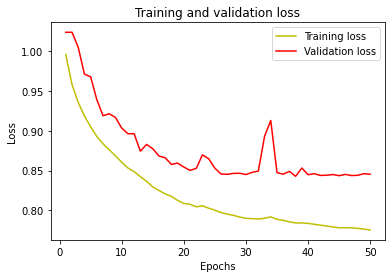

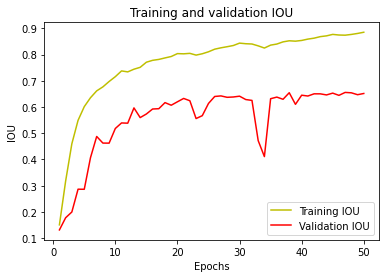

In [18]:
#Fold-5
#Plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [17]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
#BATCH 8
model2 = load_model('inceptionv3_backbone_50epochs_sandstone_f1.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_sandstone_f2.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_sandstone_f3.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_sandstone_f4.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_sandstone_f5.hdf5', compile=False)
#BATCH 16
#model2 = load_model('inceptionv3_backbone_50epochs_16_sandstone_f1.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_16_sandstone_f2.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_16_sandstone_f3.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_16_sandstone_f4.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_16_sandstone_f5.hdf5', compile=False)
#BATCH 32
#model2 = load_model('inceptionv3_backbone_50epochs_32_sandstone_f1.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_32_sandstone_f2.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_32_sandstone_f3.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_32_sandstone_f4.hdf5', compile=False)
#model2 = load_model('inceptionv3_backbone_50epochs_32_sandstone_f5.hdf5', compile=False)

# Calculating results

In [19]:
#IOU
y_pred2=model2.predict(X_test2)
y_pred2_argmax=np.argmax(y_pred2, axis=3)

In [20]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred2_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6582351


In [21]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

[[2.604270e+05 9.010000e+03 5.028700e+04 2.825000e+03]
 [1.895200e+04 1.216690e+05 7.566000e+04 7.330000e+02]
 [5.350300e+04 3.457400e+04 1.910231e+06 5.955000e+03]
 [2.652000e+03 1.815000e+03 1.865500e+04 5.449200e+04]]


In [22]:
print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

IoU for class1 is:  0.65490526
IoU for class2 is:  0.4636546
IoU for class3 is:  0.8889488
IoU for class4 is:  0.62543184


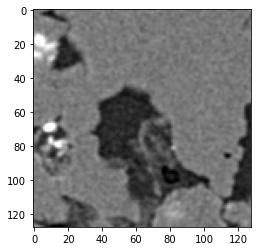

In [22]:
#Varify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')

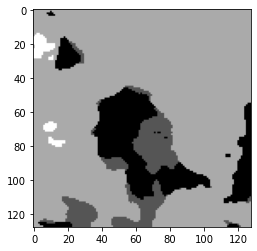

In [23]:
plt.imshow(train_masks[0], cmap='gray')

# Batch 8 - test

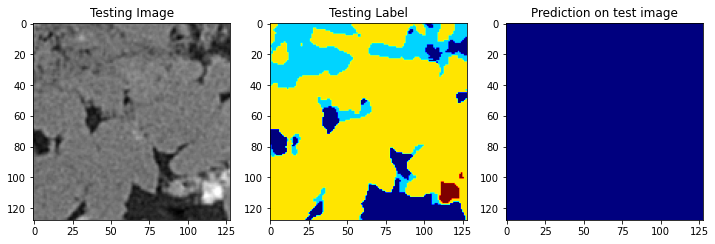

In [29]:
#Fold-1
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

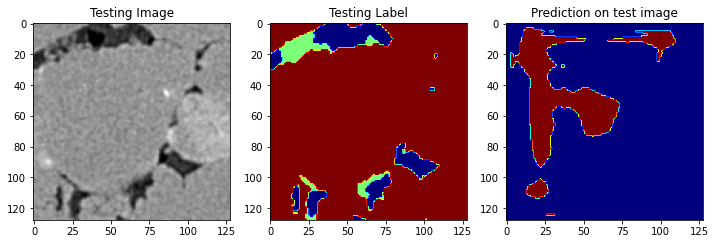

In [24]:
#Fold-2
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

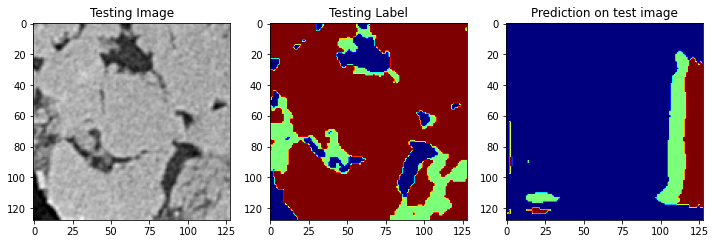

In [28]:
#Fold-3
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

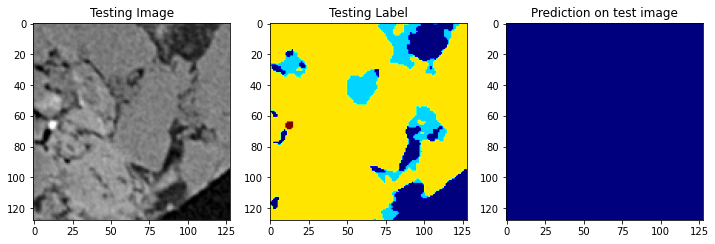

In [27]:
#Fold-4
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

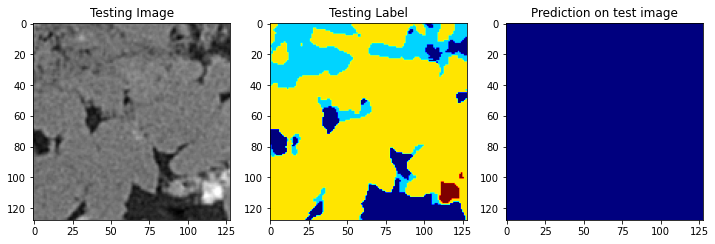

In [27]:
#Fold-5
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

# Batch 16 - test

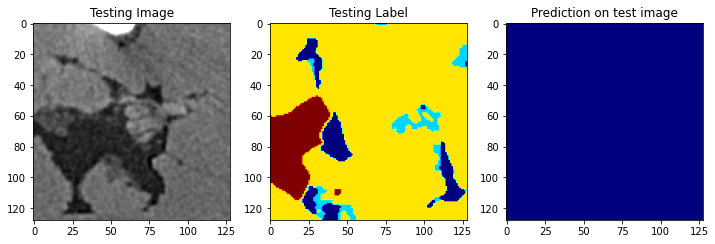

In [23]:
#Fold-1
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

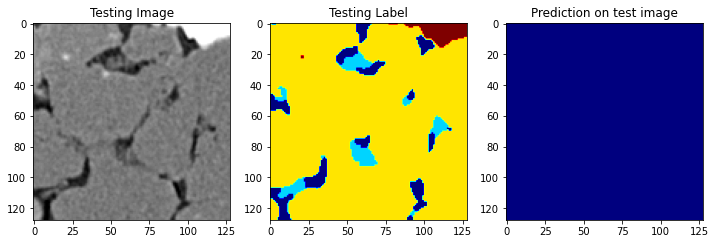

In [23]:
#Fold-2
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

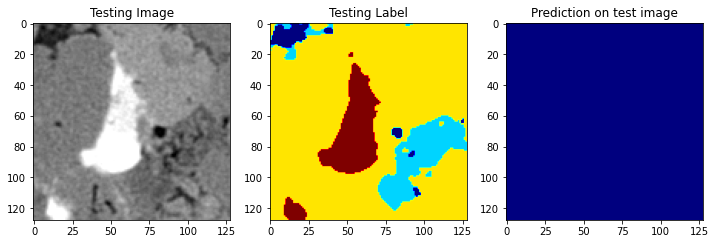

In [24]:
#Fold-3
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

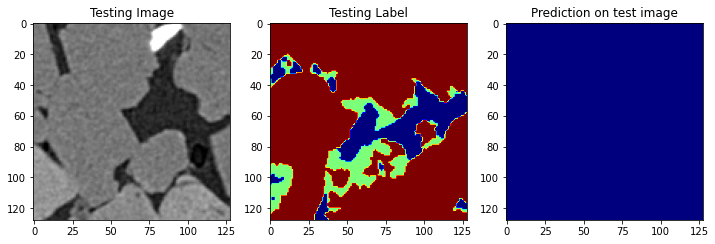

In [23]:
#Fold-4
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

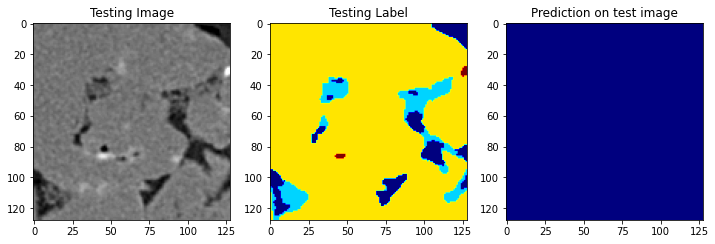

In [23]:
#Fold-5
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

# Batch 32 - test

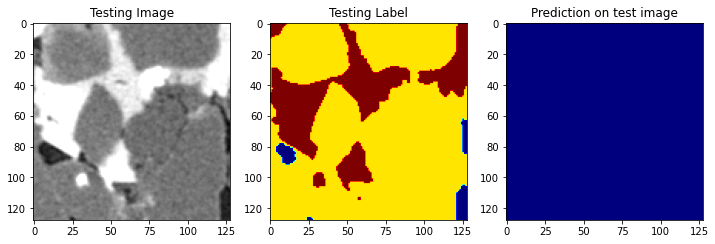

In [23]:
#Fold-1
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

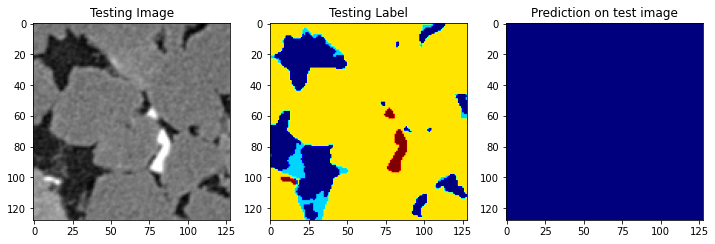

In [23]:
#Fold-2
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

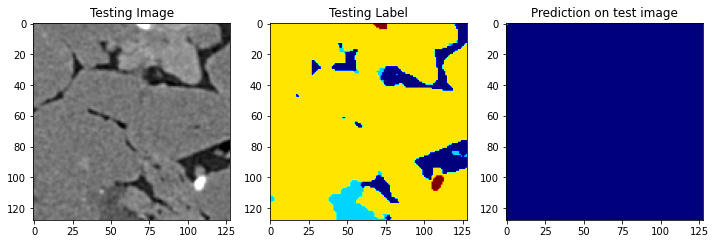

In [23]:
#Fold-3
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

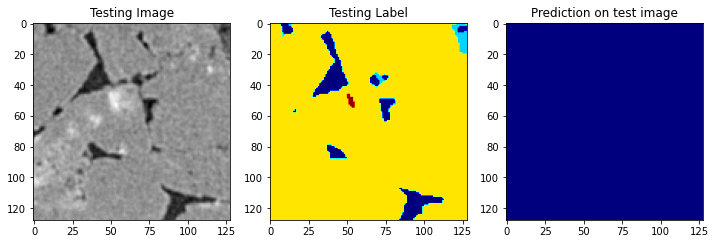

In [23]:
#Fold-4
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()

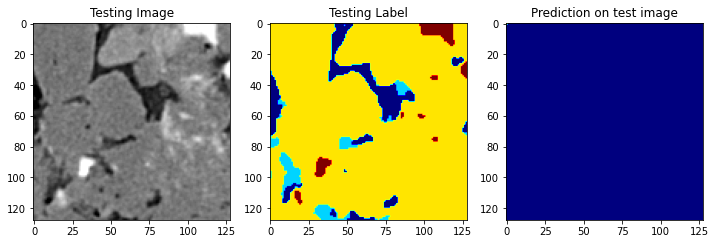

In [23]:
#Fold-5
#Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction2, cmap='jet')
plt.show()